# Spotify Music Recommender System

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
# import json

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials

import pinecone
from tqdm._tqdm_notebook import tqdm_notebook

/var/folders/8z/79m40r1d0xlgt3j50lw991x40000gn/T/ipykernel_19113/2212443471.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


## 2. Read Data

We begin by reading data from 2 files from a [Kaggle dataset](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks). The first file, `artists.csv`, contains ~1.16 million artists and their respective number of followers, genres and popularity scores. The second file, `tracks.csv`, contains ~600k songs and attributes of these songs. 

In [2]:
artists = pd.read_csv('./data/artists.csv')
display(artists.shape)
artists.head()

(1162095, 5)

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [3]:
tracks = pd.read_csv('./data/tracks.csv')
display(tracks.shape)
tracks.head()

(586672, 20)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [4]:
# # open JSON file
# x = open('./data/dict_artists.json') # this json contains a list of recommended artists for each artist, capped at 20
  
# # put JSON into dictionary
# artist_info = json.load(x)
    
# # Closing file
# x.close()

# artist_info

## 3. Data Cleaning and EDA

### Checking Data Types
Let's make sure the data types are correct for each column!

In [5]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162095 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1162095 non-null  object 
 1   followers   1162084 non-null  float64
 2   genres      1162095 non-null  object 
 3   name        1162095 non-null  object 
 4   popularity  1162095 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 44.3+ MB


In [6]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

Most of the data types look correct but some fields like `genres` in the `artists` dataframe and `artists` and `id_artists` in `tracks` LOOK like lists but they are not actually Python lists. 

### Correcting Data Types

Let's make `genres`, `artists` and `id_artists` lists!

In [7]:
# Make `genres` a list of genres
artists['genres'] = [lst.replace("[", "").replace("]", "").replace("'", "").strip().split(',') for lst in artists['genres']]

In [8]:
# # New feature: The number of genres associated with each artist
# artists['genre_cnt'] = [len(lst) for lst in artists['genres']]

In [9]:
# Make `id_artists` a list of artist ids 
tracks['id_artists'] = [lst.replace("[", "").replace("]", "").replace("'", "").strip().split(',') for lst in tracks['id_artists']]

In [10]:
# Make `artists` a list of artists
tracks['artists'] = [lst.replace("[", "").replace("]", "").replace("'", "").strip().split(',') for lst in tracks['artists']]

In [11]:
# New feature: The number of artists in the song 
tracks['artist_cnt'] = [len(lst) for lst in tracks['id_artists']]

Let's see what our dataframes look like now...

In [12]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [13]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_cnt
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1


Let's check that the `genres`, `artists` and `id_artists` fields have actually been correctly converted to lists. 

In [14]:
artists['genres'][200][0]

'pinoy hip hop'

In [15]:
tracks['artists'][1][0]

'Fernando Pessoa'

In [16]:
tracks['id_artists'][1][0]

'14jtPCOoNZwquk5wd9DxrY'

Yep, looks good, these columns are lists now. 

### Dropping duplicate tracks

There are some tracks which are duplicates which is likely because the same track can appear on multiple albums under different track ids e.g. if an album is repackaged/a deluxe version is released/a greatest hits collection is released etc. Let's drop such duplicates.

In [17]:
# Example of a track that is duplicated 
tracks[tracks['name']=='Crazy In Love (feat. Jay-Z)']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_cnt
76412,5IVuqXILoxVWvWEPm82Jxr,Crazy In Love (feat. Jay-Z),78,236133,0,"[Beyoncé, JAY-Z]","[6vWDO969PvNqNYHIOW5v0m, 3nFkdlSjzX9mRTtwJOzDYB]",2003-06-24,0.646,0.770,...,-6.596,0,0.226,0.00249,0.0,0.0715,0.681,99.165,4,2
76438,0TwBtDAWpkpM3srywFVOV5,Crazy In Love (feat. Jay-Z),73,235933,0,"[Beyoncé, JAY-Z]","[6vWDO969PvNqNYHIOW5v0m, 3nFkdlSjzX9mRTtwJOzDYB]",2003-03-10,0.664,0.758,...,-6.583,0,0.210,0.00238,0.0,0.0598,0.701,99.259,4,2
486782,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love (feat. Jay-Z),25,235933,0,"[Beyoncé, JAY-Z]","[6vWDO969PvNqNYHIOW5v0m, 3nFkdlSjzX9mRTtwJOzDYB]",2003-06-23,0.664,0.758,...,-6.583,0,0.210,0.00238,0.0,0.0598,0.701,99.259,4,2


In [18]:
tracks['artists_str'] = [','.join(lst) for lst in tracks['artists']]
tracks['artists_id_str'] = [','.join(lst) for lst in tracks['id_artists']]

In [19]:
# Check shape of tracks before dropping duplicates
tracks.shape

(586672, 23)

In [20]:
tracks.drop_duplicates(subset=['name', 'artists_str', 'artists_id_str'], # we want to find duplicates by all columns EXCEPT id
                       keep='first', # drop duplicates except for the first occurrence
                       inplace=True)

In [21]:
# Check shape of tracks AFTER dropping duplicates 
tracks.shape

(526784, 23)

In [22]:
# Check the earlier example of a track that is duplicated 
tracks[tracks['name']=='Crazy In Love (feat. Jay-Z)']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_cnt,artists_str,artists_id_str
76412,5IVuqXILoxVWvWEPm82Jxr,Crazy In Love (feat. Jay-Z),78,236133,0,"[Beyoncé, JAY-Z]","[6vWDO969PvNqNYHIOW5v0m, 3nFkdlSjzX9mRTtwJOzDYB]",2003-06-24,0.646,0.77,...,0.226,0.00249,0.0,0.0715,0.681,99.165,4,2,"Beyoncé, JAY-Z","6vWDO969PvNqNYHIOW5v0m, 3nFkdlSjzX9mRTtwJOzDYB"


Based on the shape of `tracks` df before and after dropping duplicates, as well as the 'Crazy In Love' example, we can see that duplicates have been successfully dropped!

### Adding `genre` to each track

The `tracks` dataframe currently does not have any genre information about each song which would be really useful information. Fortunately, the `artists` dataframe contains genre information for each artist. Let's combine these 2 dataframes so that we can get genre information for each song, based on the artist for that song. In order to do this, we will...
1. Explode each song in `tracks` by artist(s) in the song e.g. 1 row for 'Crazy in Love' by [Beyoncé, JAY-Z] will become 2 rows - 'Crazy in Love' by 'Beyoncé' and 'Crazy in Love' by 'Jay-Z'.
2. Merge the `artists` dataframe with this new dataframe we created in step 1. 

In [23]:
# Explode by artist id since we'll use artist id for the merge with `artists` df 
tracks_exploded = tracks.explode('id_artists')

In [24]:
# Merge tracks df with artists df
combined_df = tracks_exploded.merge(artists, how='left', left_on='id_artists', right_on='id')
combined_df.head()

,id_x,name_x,popularity_x,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,artist_cnt,artists_str,artists_id_str,id_y,followers,genres,name_y,popularity_y
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,104.851,3,1,Uli,45tIt06XoI0Iio4LBEVpls,45tIt06XoI0Iio4LBEVpls,91.0,[],Uli,4.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,102.009,1,1,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,14jtPCOoNZwquk5wd9DxrY,3.0,[],Fernando Pessoa,0.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,130.418,5,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"[tango, vintage tango]",Ignacio Corsini,23.0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,169.980,3,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"[tango, vintage tango]",Ignacio Corsini,23.0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,103.220,4,1,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,3BiJGZsyX9sJchTqcSA7Su,11327.0,"[adult standards, big band, easy listening, ...",Dick Haymes,35.0


Now that we've merged the 2 dataframes, let's do some cleanup by removing columns that no longer necessary and renaming columns with duplicated names clearly. 

In [25]:
# Get the names of all the columns in combined df
combined_df.columns

Index(['id_x', 'name_x', 'popularity_x', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'artist_cnt',
       'artists_str', 'artists_id_str', 'id_y', 'followers', 'genres',
       'name_y', 'popularity_y'],
      dtype='object')

In [26]:
# Drop columns
combined_df.drop(columns=['id_y', 'name_y'], inplace=True)
# Rename columns
combined_df.rename(columns={'id_x':'track_id', 'name_x':'track_name', 'popularity_x':'track_popularity',
                   'followers':'artist_followers', 'popularity_y':'artist_popularity'},
                   inplace=True)

In [27]:
# Reset index
combined_df.reset_index(drop=True, inplace=True)

In [28]:
combined_df.head()

,track_id,track_name,track_popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,liveness,valence,tempo,time_signature,artist_cnt,artists_str,artists_id_str,artist_followers,genres,artist_popularity
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.151,0.127,104.851,3,1,Uli,45tIt06XoI0Iio4LBEVpls,91.0,[],4.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.148,0.655,102.009,1,1,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,3.0,[],0.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.212,0.457,130.418,5,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"[tango, vintage tango]",23.0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.104,0.397,169.980,3,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"[tango, vintage tango]",23.0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.311,0.196,103.220,4,1,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,11327.0,"[adult standards, big band, easy listening, ...",35.0


### Remove missing values

In [29]:
# sum([np.isnan(num) for num in combined_df['artist_popularity']])

In [30]:
# Remove missing values in artist popularity 
combined_df['artist_popularity'].fillna(0.0, inplace=True)

In [31]:
# sum([np.isnan(num) for num in combined_df['artist_popularity']])

In [32]:
# Deal with missing genres and NANs
combined_df['genres'].fillna('missing_genre', inplace=True)
combined_df['genres'] = [['missing_genre'] if lst[0]=='' else lst for lst in combined_df['genres']]

In [33]:
# Change 
combined_df['genres'] = [','.join(lst) for lst in combined_df['genres']]

In [34]:
combined_df = combined_df.drop_duplicates(subset=['track_id'])
combined_df.reset_index(drop=True, inplace=True)

In [35]:
display(combined_df.shape)
combined_df.head()

(526784, 26)

,track_id,track_name,track_popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,liveness,valence,tempo,time_signature,artist_cnt,artists_str,artists_id_str,artist_followers,genres,artist_popularity
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.151,0.127,104.851,3,1,Uli,45tIt06XoI0Iio4LBEVpls,91.0,missing_genre,4.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.148,0.655,102.009,1,1,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,3.0,missing_genre,0.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.212,0.457,130.418,5,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango, vintage tango",23.0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.104,0.397,169.980,3,1,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango, vintage tango",23.0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.311,0.196,103.220,4,1,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,11327.0,"adult standards, big band, easy listening, lou...",35.0


### EDA: Number of Artists Per Track

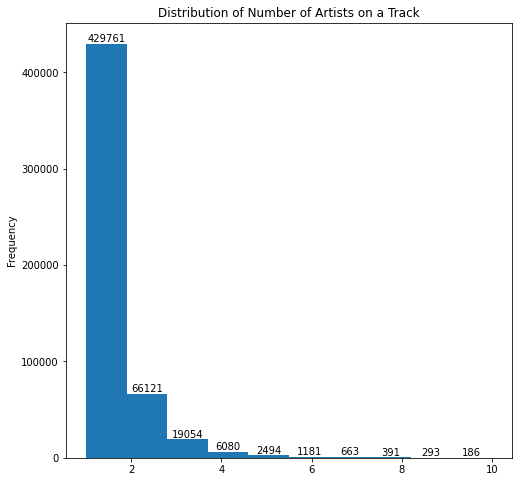

In [36]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Number of Artists on a Track')
ax = tracks['artist_cnt'].plot(kind='hist', bins=10, range=[1, 10])
ax.bar_label(ax.containers[0])
plt.show()

In [37]:
# Find the cumulative frequency of artist count
artist_cnt_df = pd.DataFrame(tracks['artist_cnt'].value_counts().cumsum())
artist_cnt_df['%'] = artist_cnt_df['artist_cnt']/tracks.shape[0]
artist_cnt_df.head()

,artist_cnt,%
1,429761,0.815820
2,495882,0.941338
3,514936,0.977509
4,521016,0.989051
5,523510,0.993785


~80% of the tracks have only 1 artist and more than 99% of the tracks have 5 or less artists on the track. 

In [38]:
# Number of Artists by Genre 

In [39]:
# Get a list of all the unique genres in the artists df 
genre_lst = []
for genres in artists['genres']:
    # print(genres)
    for genre in genres:
        # genre.replace(" '", "")
        # genre.replace("'", "")
        genre_lst.append(genre.strip())

In [40]:
list(set(genre_lst))[:5]

['', 'baglama', 'musica triste brasileira', 'rock cristiano', 'boston hip hop']

### Create a `year` feature for `combined_df` and `tracks`

In [41]:
combined_df['release_year'] = pd.to_datetime(combined_df['release_date']).dt.year
tracks['release_year'] = pd.to_datetime(tracks['release_date']).dt.year

### EDA: Number of Tracks by Year

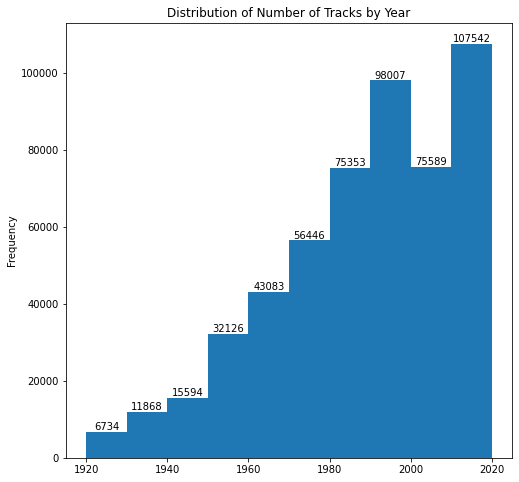

In [42]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Number of Tracks by Year')
ax = tracks['release_year'].plot(kind='hist', bins=10, range=[1920, 2020])
ax.bar_label(ax.containers[0])
plt.show()

## 4. Preprocessing 
In this section, we prepare data by embedding it into vectors so that we can calculate similarity measures between our database of songs and a user's music taste. 

1. Feature engineering 
    - Create a `year` feature for release date  
2. Scaling
    - Let's scale `track_popularity`, `artist_popularity` and musical features of a song to a scale of 0-1 
3. One-hot encoding 
    - Let's OHE the `year` feature
4. TF-IDF the genres 
5. Drop unnecessary features

### 4.2 Scaling using `MinMaxScaler()`

Let's build a function that takes in a dataframe, a list of columns in the dataframe and returns a dataframe of the specified columns after scaling. 

In [43]:
def scale_df(col_lst, df=combined_df):
    # Instantiate scaler 
    mms = MinMaxScaler()
    
    # Fit and transform the data 
    transformed_df = mms.fit_transform(df[col_lst])

    return pd.DataFrame(transformed_df, columns=col_lst)

In [44]:
def ohe_df(col_lst, df=combined_df): 
    transformed_df = pd.get_dummies(df[col_lst], columns=col_lst)
    
    return transformed_df

### 4.4 TF-IDF Vectoriser 
[insert explanation and diagram]

In [45]:
def tvec_df(col, df=combined_df):
    # Instantiate tfidfvectorizer
    tvec = TfidfVectorizer()

    # Fit and transform the data
    tvec_matrix = tvec.fit_transform(df[col])
    
    # Put transformed data into a df
    df = pd.DataFrame(tvec_matrix.toarray(), columns=tvec.get_feature_names())
    
    return df

### 4.5 Combine all preprocessing!

Let's build a function that takes in a dataframe and returns the vectorized dataframe. 

In [46]:
combined_df.columns

Index(['track_id', 'track_name', 'track_popularity', 'duration_ms', 'explicit',
       'artists', 'id_artists', 'release_date', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'artist_cnt', 'artists_str', 'artists_id_str', 'artist_followers',
       'genres', 'artist_popularity', 'release_year'],
      dtype='object')

In [47]:
def create_vector(df=combined_df):
    scale_ft = ['track_popularity', 'danceability', 'energy', 
               'key', 'loudness', 'mode', 
               'speechiness', 'acousticness', 'instrumentalness', 
               'liveness', 'valence', 'tempo', 'time_signature', 
               'artist_popularity']
    ohe_ft = ['explicit', 'release_year']
    tvec_ft = 'genres'
    
    final_df = pd.concat([df['track_id'], 
                          scale_df(scale_ft), 
                          ohe_df(ohe_ft), 
                          tvec_df(tvec_ft)], 
                         axis=1)
    
    return final_df

### 4.6 Final cleaning and split song dataset for upload to Pinecone

Pinecone has limits of about x00k songs. Out of the 500k+ songs we currently have, we will randomly select 450k songs for upload. Then, we will split these 450k songs into batches for upload to Pinecone. 

In [48]:
# Generate a random list of indexes 
random.seed(42)
random_index = random.sample(range(combined_df.shape[0]), 450000)

# Create final df
final_songs = combined_df.iloc[random_index, :]
final_songs.shape

(450000, 27)

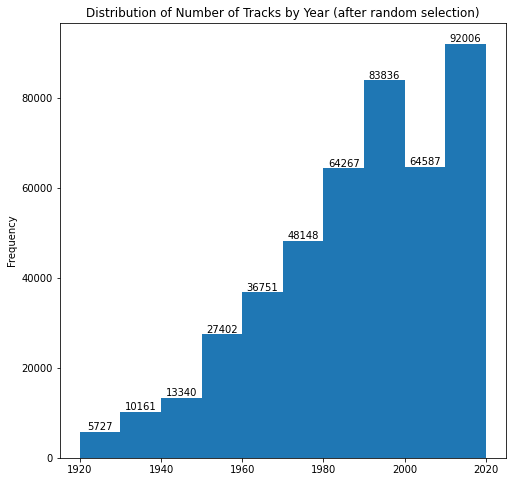

In [49]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Number of Tracks by Year (after random selection)')
ax = final_songs['release_year'].plot(kind='hist', bins=10, range=[1920, 2020])
ax.bar_label(ax.containers[0])
plt.show()

Distribution looks pretty similar to the original dataset with 500k+ songs! Let's proceed with these randomly chosen 450k tracks. 

In [50]:
all_song_ft = create_vector()

In [51]:
display(all_song_ft.shape)

(526784, 2408)

In [52]:
final_song_ft = all_song_ft.iloc[random_index, :]
final_song_ft.shape

(450000, 2408)

In [53]:
# Reset the index one more time
final_song_ft.reset_index(drop=True, inplace=True)
final_song_ft.head()

,track_id,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,zikir,zillertal,zim,zither,zolo,zouglou,zouk,zuliana,zurich,zydeco
0,1qFqi7NahjuFxGV3H2FNmb,0.16,0.468214,0.337,0.454545,0.740103,1.0,0.052317,0.696787,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4iUxT3nhVmAsUj7Jm5ZeJy,0.19,0.162462,0.267,0.818182,0.663011,1.0,0.038620,0.928715,0.979000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18Gd6vSbxKS4mrEvjz14oS,0.15,0.383451,0.297,0.181818,0.667875,0.0,0.033368,0.392570,0.000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32QnXosZq7A11knnBAEqk7,0.59,0.717457,0.315,0.000000,0.746283,1.0,0.035015,0.744980,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0JBjiB2QZSYPVUEnUmSroj,0.38,0.507568,0.928,0.000000,0.835934,1.0,0.032750,0.002912,0.000010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pickle variables! 

In [54]:
all_song_ft.to_pickle('./data/all_song_ft.pkl')
final_song_ft.to_pickle('./data/final_song_ft.pkl')
# final_vector.to_pickle('./data/final_vector.pkl')